In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

100% 1.14G/1.14G [00:24<00:00, 30.1MB/s]
100% 1.14G/1.14G [00:25<00:00, 49.0MB/s]


In [4]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [7]:
batch_size = 48

img_height = 150
img_width = 150

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.4,shear_range=0.3,vertical_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [9]:
train = image_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',color_mode='grayscale',batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,target_size=(img_height,img_width),shuffle=False,class_mode='binary',color_mode='grayscale',batch_size=batch_size)
valid = test_data_gen.flow_from_directory(valid_path,target_size=(img_height,img_width),class_mode='binary',color_mode='grayscale',batch_size=batch_size)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


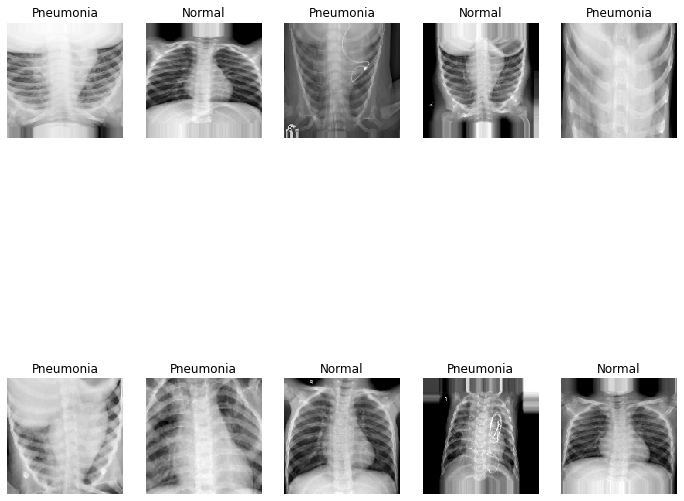

In [10]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:'Normal',1:'Pneumonia'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')

    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break

    plt.tight_layout()
    plt.show()

In [16]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Convolution2D
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras import optimizers
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [23]:
output_dim=10
nb_epoch = 50
input_shape = (150, 150, 1)

In [24]:
#Initialize model
model = Sequential()

#CNN Layer 1
#input: 28X28 images with 1 channel -> (28X28X1) tensors.
#this applies 64 convolution filters of size 3X3 each.
model.add(ZeroPadding2D((1,1), input_shape=input_shape))
model.add(Convolution2D(filters=64, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.4))

#CNN Layer 2
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(filters=64, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Dropout(0.4))

#Flatten the output before feeding these to the fully connected Neurons                                    
model.add(Flatten())

#Fully connected Layers
model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))

#Using adam as our optimzer
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

#Get a summary of the model.
print(model.summary())

#Compile the model
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_4 (ZeroPaddin (None, 152, 152, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 64)      640       
_________________________________________________________________
dropout_8 (Dropout)          (None, 150, 150, 64)      0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 152, 152, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 75, 75, 64)       

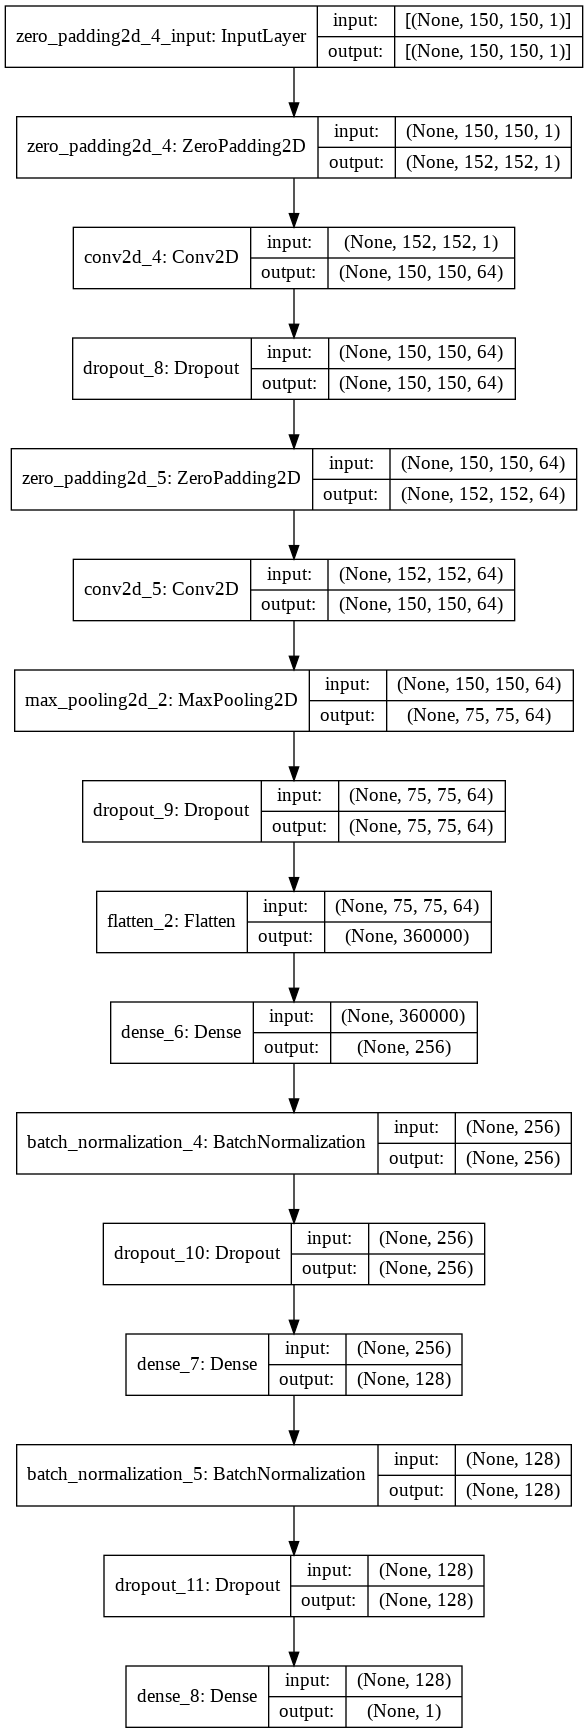

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=True)

In [26]:
early = EarlyStopping(monitor="val_loss",mode="min",patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=1,factor=0.3,min_lr=0.000001)
callbacks_list = [early,learning_rate_reduction]

In [27]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes),train.classes)
cw = dict(zip(np.unique(train.classes),weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [28]:
model.fit(train,epochs=25,validation_data=valid,class_weight=cw,callbacks=callbacks_list,batch_size=512)

Epoch 1/25
88/88 [==============================] - 703s 8s/step - loss: 0.7765 - accuracy: 0.6046 - val_loss: 0.4285 - val_accuracy: 0.8548
Epoch 2/25
88/88 [==============================] - 698s 8s/step - loss: 0.4882 - accuracy: 0.7743 - val_loss: 0.7843 - val_accuracy: 0.7433
Epoch 3/25
88/88 [==============================] - 698s 8s/step - loss: 0.4604 - accuracy: 0.7972 - val_loss: 0.7878 - val_accuracy: 0.7433

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
Epoch 4/25
88/88 [==============================] - 699s 8s/step - loss: 0.4989 - accuracy: 0.7914 - val_loss: 1.0573 - val_accuracy: 0.7433


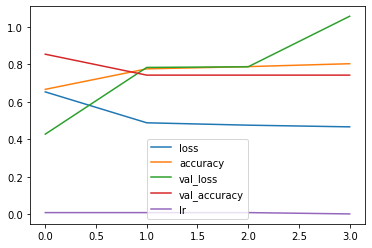

In [30]:
pd.DataFrame(model.history.history).plot()

In [31]:
test_acc = model.evaluate(test)
print('Testing accuracy is - ',test_acc[1]*100,'%')

13/13 [==============================] - 26s 2s/step - loss: 1.5773 - accuracy: 0.6250
Testing accuracy is -  62.5 %
